# SetUp

In [1]:
%matplotlib inline
import d2ltvm
import tvm
from tvm import te
import inspect
from IPython import display
import numpy as np
from matplotlib import pyplot as plt
import timeit

successd...



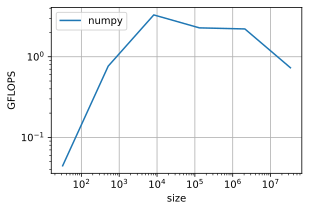

In [2]:
sizes = 2 ** np.arange(5, 29, 4)
np_add = lambda n : timeit.Timer(setup='import numpy as np\n'
                                'import d2ltvm\n'
                                'a, b, c = d2ltvm.get_abc(%d)' % n,
                                stmt='np.add(a, b, out=c)')

exe_times = [d2ltvm.bench_workload(np_add(n).timeit) for n in sizes]
np_gflops = sizes / 1e9 / np.array(exe_times)
d2ltvm.plot_gflops(sizes, [np_gflops], ['numpy'])

As we can see that the performance first increases with the vector length, which is due to the system overhead domination when the workload is small. The performance then decreases when we cannot fit all data into the cache.

# Default Schedule

In [3]:
def bench_vector_add_tvm(func, sizes, target):
    def workload(nrepeats):
        timer = mod.time_evaluator(mod.entry_name, dev=ctx, number=nrepeats)
        return timer(a, b, c).mean * nrepeats
    times = []
    for n in sizes:
        s, (A, B, C) = func(int(n))
        mod = tvm.build(s, [A, B, C], target)
        ctx = tvm.device(target, 0)
        a, b, c = d2ltvm.get_abc(n, lambda x: tvm.nd.array(x, device=ctx))
        times.append(d2ltvm.bench_workload(workload))
    return sizes / 1e9 / np.array(times)

In [4]:
def default(n):
    A, B, C = d2ltvm.vector_add(n)
    s = te.create_schedule(C.op)
    return s, (A, B, C)

s, args = default(64)
print(tvm.lower(s, args, simple_mode=True))

@main = primfn(a_1: handle, b_1: handle, c_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {a: Buffer(a_2: Pointer(float32), float32, [64], []),
             b: Buffer(b_2: Pointer(float32), float32, [64], []),
             c: Buffer(c_2: Pointer(float32), float32, [64], [])}
  buffer_map = {a_1: a, b_1: b, c_1: c}
  preflattened_buffer_map = {a_1: a_3: Buffer(a_2, float32, [64], []), b_1: b_3: Buffer(b_2, float32, [64], []), c_1: c_3: Buffer(c_2, float32, [64], [])} {
  for (i: int32, 0, 64) {
    c[i] = (a[i] + b[i])
  }
}




In [5]:
target = 'llvm -mcpu=skylake'
mod = tvm.build(s, args, target)
print(mod.get_source()[:500])

; ModuleID = 'TVMMod'
source_filename = "TVMMod"
target datalayout = "e-m:e-p270:32:32-p271:32:32-p272:64:64-i64:64-f80:128-n8:16:32:64-S128"
target triple = "x86_64-unknown-linux-gnu"

%0 = type { i8*, %1, i32, %2, i64*, i64*, i64 }
%1 = type { i32, i32 }
%2 = type { i8, i8, i16 }

@__TVMAPISetLastError = linkonce dllexport local_unnamed_addr global void (i8*)* null, align 8
@.str = private constant [69 x i8] c"Assert fail: (num_args == 3), default_function: num_args should be 3\00", align 1
@.


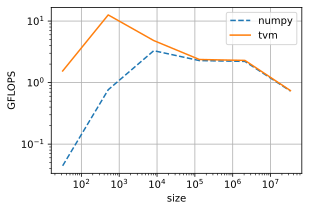

In [6]:
default_gflops = bench_vector_add_tvm(default, sizes, target)
d2ltvm.plot_gflops(sizes, [np_gflops, default_gflops], ['numpy', 'tvm'])

When the vector size is small, the default scheduling outperforms NumPy, which means that in this method the function call overhead of TVM is smaller than NumPy. It’s not surprising to find the performance degrades when increasing the vector size as the data cannot fit into the last level cache.

# Parallelization

In [7]:
def parallel(n):
    s, (A, B, C) = default(n)
    s[C].parallel(C.op.axis[0])
    return s, (A, B, C)

s, args = parallel(64)
print(tvm.lower(s, args, simple_mode=True))

@main = primfn(a_1: handle, b_1: handle, c_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {a: Buffer(a_2: Pointer(float32), float32, [64], []),
             b: Buffer(b_2: Pointer(float32), float32, [64], []),
             c: Buffer(c_2: Pointer(float32), float32, [64], [])}
  buffer_map = {a_1: a, b_1: b, c_1: c}
  preflattened_buffer_map = {a_1: a_3: Buffer(a_2, float32, [64], []), b_1: b_3: Buffer(b_2, float32, [64], []), c_1: c_3: Buffer(c_2, float32, [64], [])} {
  for (i: int32, 0, 64) "parallel" {
    c[i] = (a[i] + b[i])
  }
}




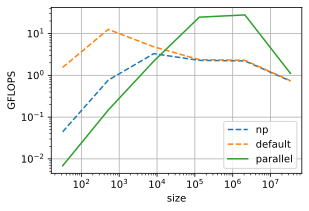

In [9]:
parallel_gflops = bench_vector_add_tvm(parallel, sizes, target)
d2ltvm.plot_gflops(sizes, [np_gflops, default_gflops, parallel_gflops], ['np', 'default', 'parallel'])

Comparing the results we obtained before, parallelization significantly improves the performance when the workloads are large, e.g. vector lengths beyond 104. However, the parallelization overhead impact the performance for small workloads, where single thread is even faster. The performance drops at a larger size as multi-core comes in play, leading to a larger amount of L2 cache in total.

# Vectorization

In [11]:
def vectorization(n):
    s, (A, B, C) = default(n)
    outer, inner = s[C].split(C.op.axis[0], factor=8)
    s[C].parallel(outer)
    s[C].vectorize(inner)
    return s, (A, B, C)

s, args = vectorization(128)
print(tvm.lower(s, args, simple_mode=True))

@main = primfn(a_1: handle, b_1: handle, c_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {a: Buffer(a_2: Pointer(float32), float32, [128], []),
             b: Buffer(b_2: Pointer(float32), float32, [128], []),
             c: Buffer(c_2: Pointer(float32), float32, [128], [])}
  buffer_map = {a_1: a, b_1: b, c_1: c}
  preflattened_buffer_map = {a_1: a_3: Buffer(a_2, float32, [128], []), b_1: b_3: Buffer(b_2, float32, [128], []), c_1: c_3: Buffer(c_2, float32, [128], [])} {
  for (i.outer: int32, 0, 16) "parallel" {
    let cse_var_1: int32 = (i.outer*8)
    c[ramp(cse_var_1, 1, 8)] = (a[ramp(cse_var_1, 1, 8)] + b[ramp(cse_var_1, 1, 8)])
  }
}




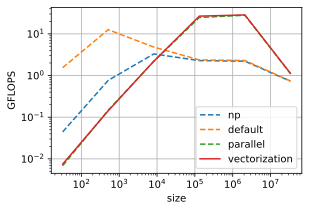

In [12]:
vectorization_gflops = bench_vector_add_tvm(vectorization, sizes, target)
d2ltvm.plot_gflops(sizes, [np_gflops, default_gflops, parallel_gflops, vectorization_gflops], ['np', 'default', 'parallel', 'vectorization'])

The performance of the vectorized version is almost as the plain parallelization version. It’s partially because the vector add is bottlenecked by memory bandwidth instead of computation, while SIMD only helps the latter. We will see it helps more on computation intensive workloads such as matrix multiplication later.

# Summary
1.The default scheduling generates naive single-thread CPU program. \
2.Parallelization improves performance for large workloads. \
3.We can split a for-loop and then vectorize the inner loop if the system supports SIMD.